<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-2--online-ad-clicks/02_making_predictions_using_central_limit_theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Making predictions using the central limit theorem

The normal distribution is a bell-shaped curve.The
curve arises naturally from random data sampling due to the central limit theorem. 

Furthermore, the theorem predicts
a narrowing of that curve as the size of each frequency sample goes up. 

In other words, the distribution’s standard deviation should decrease as the sampling size
increases.

The central limit theorem lies at the heart of all classic statistics.

So, we probe the theorem in great detail using the computational power of SciPy. Eventually, we learn how to use the theorem to make predictions from limited data.

##Setup

In [1]:
from collections import defaultdict
import itertools

import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt

In [2]:
# Penalizing centers using the squared distance from the minimum
def squared_distance(value1, value2):
  return (value1 - value2) ** 2

In [3]:
# Penalizing centers using the total sum of squared distances
def sum_of_squared_distances(value, measurements):
  return sum(squared_distance(value, m) for m in measurements)

In [4]:
# Computing California’s sum of squares
def sum_of_squares(data):
  mean = np.mean(data)
  return sum(squared_distance(value, mean) for value in data)

In [5]:
# Computing the variance from mean squared distance
def variance(data):
  mean = np.mean(data)
  return np.mean([squared_distance(value, mean) for value in data])

In [6]:
# Computing the weighted variance using np.average
def weighted_variance(data, weights):
  mean = np.average(data, weights=weights)
  squared_distances = [squared_distance(value, mean) for value in data]
  return np.average(squared_distances, weights=weights)

assert weighted_variance([75, 77], [9, 1]) == np.var(9 * [75] + [77])

##Manipulating the normal distribution

Let’s generate a normal distribution by plotting a histogram of coin-flip samples. Our
input into the histogram will contain 100,000 head-count frequencies. Computing the
frequencies will require us to sample a series of coin flips 100,000 times.

If we use the sample size to divide the sum of values in
the sample, we will compute the observed head-count frequency. Conceptually, this
frequency is equal to simply taking the sample’s mean.

In [7]:
# Computing head-count frequencies from the mean
np.random.seed(0)

sample_size = 10000
sample = np.array([np.random.binomial(1, 0.5) for _ in range(sample_size)])
head_count = sample.sum()

head_count_frequency = head_count / sample_size
# The head-count frequency is identical to the sample mean.
assert head_count_frequency == sample.mean()

Of course, we can compute all 100,000 head-count frequencies in a single line of
code.

In [8]:
#Computing 100,000 head-count frequencies
np.random.seed(0)

frequencies = np.random.binomial(sample_size, 0.5, 100000) / sample_size

Each sampled frequency equals the mean of 10,000 randomly flipped coins.

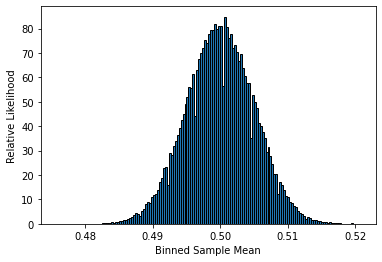

In [9]:
# Visualizing sample means in a histogram
sample_means = frequencies
likelihoods, bin_edges, _ = plt.hist(sample_means, bins="auto", edgecolor="black", density=True)

plt.xlabel("Binned Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

The histogram is shaped like a normal distribution. Let’s calculate the distribution’s
mean and standard deviation.

In [10]:
# Computing the mean and standard deviation of a histogram
mean_normal = np.average(bin_edges[:-1], weights=likelihoods)
var_normal = weighted_variance(bin_edges[:-1], likelihoods)
std_normal = var_normal ** 0.5

print(f"Mean is approximately {mean_normal:.2}")
print(f"Standard deviation is approximately {std_normal:.3f}")

Mean is approximately 0.5
Standard deviation is approximately 0.005


The distribution’s mean is approximately 0.5, and its standard deviation is approximately
0.005. 

In a normal distribution, these values can be computed directly from
the distribution’s peak. We just need the peak’s x-value and y-value coordinates. 

The x-value equals the distribution’s mean, and the standard deviation is equal to the inverse of the y-value multiplied by $(2\pi)^{1/2}$

In [11]:
# Computing mean and standard deviation from peak coordinates
peak_x_value = bin_edges[likelihoods.argmax()]
print(f"Mean is approximately {peak_x_value:.2f}")

peak_y_value = likelihoods.max()
print(f"Max y-value {peak_y_value:.2f}")
std_from_peak = (peak_y_value * (2 * math.pi) ** 0.5) ** -1
print(f"Standard deviation is approximately {std_from_peak:.3f}")

Mean is approximately 0.50
Max y-value 84.85
Standard deviation is approximately 0.005


Additionally, we can compute the mean and standard deviation simply by calling
`stats.norm.fit(sample_means)`. 

This SciPy method returns the two parameters
required to re-create the normal distribution formed by our data.

In [12]:
# Computing mean and standard deviation using stats.norm.fit
fitted_mean, fitted_std = stats.norm.fit(sample_means)
print(f"Mean is approximately {fitted_mean:.2f}")
print(f"Standard deviation is approximately {fitted_std:.3f}")

Mean is approximately 0.50
Standard deviation is approximately 0.005


The computed mean and standard deviation can be used to reproduce our normal
curve. We can regenerate the curve by calling `stats.norm.pdf(bin_edges, fitted_mean, fitted_std)`.

A probability density function is like a probability
mass function but with one key difference: it does not return probabilities.

Instead, it returns relative likelihoods.

As we know, relative likelihoods are the y-axis
values of a curve whose total area equals 1.0. 

Unlike probabilities, these likelihoods
can equal values that are greater than 1.0. 

Despite this, the total area beneath a plotted
likelihood interval still equals the probability of observing a random value within
that interval.

Let’s compute the relative likelihoods using `stats.norm.pdf`.



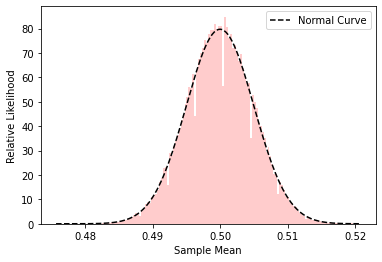

In [13]:
# Computing normal likelihoods using stats.norm.pdf
normal_likelihoods = stats.norm.pdf(bin_edges, fitted_mean, fitted_std)

plt.plot(bin_edges, normal_likelihoods, color="k", linestyle="--", label="Normal Curve")
plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
plt.legend()
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

The curve’s peak sits at an x-axis position of 0.5 and rises to a y-axis position of approximately 80. As a reminder, the peak’s x and
y coordinates are a direct function of `fitted_mean` and `fitted_std`.

To emphasize this
important relationship, let’s do a simple exercise: we’ll shift the peak 0.01 units to the
right while also doubling the peak’s height.

Well, the peak’s axis is equal to the mean, so we adjust the input mean to `fitted_mean + 0.01`. Also, the peak’s height is inversely proportional to the standard deviation. Therefore,
inputting `fitted_std / 2` should double the height of the peak.



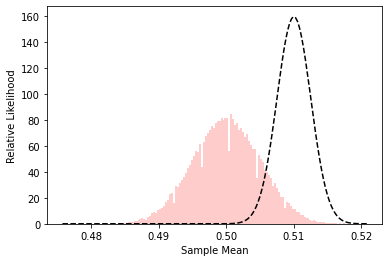

In [14]:
# Manipulating a normal curve’s peak coordinates
adjusted_likelihoods = stats.norm.pdf(bin_edges, fitted_mean + 0.01, fitted_std / 2)

plt.plot(bin_edges, adjusted_likelihoods, color="k", linestyle="--")
plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

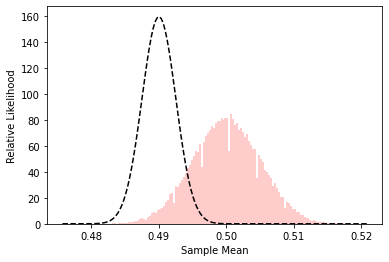

In [15]:
adjusted_likelihoods = stats.norm.pdf(bin_edges, fitted_mean - 0.01, fitted_std / 2)

plt.plot(bin_edges, adjusted_likelihoods, color="k", linestyle="--")
plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

###Comparing two sampled normal curves

SciPy allows us to explore and adjust the shape of the normal distribution based on
the inputted parameters. Also, the values of these input parameters depend on how
we sample random data.

Let’s quadruple the coin-flip sample size to 40,000 and plot
the resulting distribution changes.

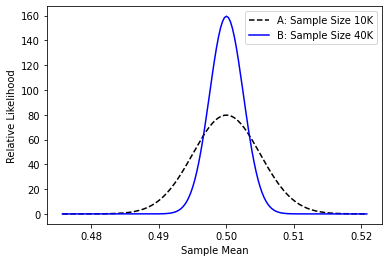

In [16]:
# Plotting two curves with different samples sizes
np.random.seed(0)

new_sample_size = 40000
new_head_counts = np.random.binomial(new_sample_size, 0.5, 100000)
new_mean, new_std = stats.norm.fit(new_head_counts / new_sample_size)
new_likelihoods = stats.norm.pdf(bin_edges, new_mean, new_std)

plt.plot(bin_edges, normal_likelihoods, color="k", linestyle="--", label="A: Sample Size 10K")
plt.plot(bin_edges, new_likelihoods, color="b", label="B: Sample Size 40K")
plt.legend()
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

Both normal distributions are centered around the sample mean value of 0.5. However,
the distribution with the larger sample size is more narrowly centered around its
peak.

As we observed that
as the sample size increases, the peak location stays constant while the area around
the peak contracts in width. The narrowing of the peak leads to a drop in the confidence
interval range. A confidence interval represents the likely value range covering
the true probability of heads.

Let’s calculate the 95% confidence interval for the true Bernoulli mean using normal
distribution B.

In [17]:
# Computing a confidence interval
mean, std = new_mean, new_std
start, end = stats.norm.interval(0.95, mean, std)
print(f"The true mean of the sampled binomial distribution is between {start:.3f} and {end:.3f}")

The true mean of the sampled binomial distribution is between 0.495 and 0.505


In fact, that mean is equal to exactly 0.5. We can confirm
this.

In [18]:
# Confirming the Bernoulli mean
assert stats.binom.mean(1, 0.5) == 0.5

Let’s now attempt to estimate the variance of the Bernoulli distribution based on the
plotted normal curves.

At first glance, this seems like a difficult task.

Although the
means of the two plotted distributions remain constant at 0.5, their variances shift
noticeably. The relative shift in variance can be estimated by comparing peaks. 

Thus, increasing the sample size fourfold from 10,000 to
40,000 leads to a fourfold decrease in the variance.

In [19]:
# Assessing shift in variance after increased sampling
variance_ratio = (new_std ** 2) / (fitted_std ** 2)
print(f"The ratio of variances is approximately {variance_ratio:.2f}")

The ratio of variances is approximately 0.25


It appears that variance is inversely proportional to sample size. If so, a fourfold
decrease in sample size from 10,000 to 2,500 should generate a fourfold increase in
the variance.

Let’s generate some head counts using a sample size of 2,500 and confirm
if this is the case.

In [20]:
# Assessing shift in variance after decreased sampling
np.random.seed(0)

reduced_sample_size = 2500
head_counts = np.random.binomial(reduced_sample_size, 0.5, 100000)
_, std = stats.norm.fit(head_counts / reduced_sample_size)

variance_ratio = (std ** 2) / (fitted_std ** 2)
print(f"The ratio of variances is approximately {variance_ratio:.1f}")

The ratio of variances is approximately 4.0


Yes! A fourfold decrease in the sample size leads to a fourfold increase in the variance.

Thus, if we decrease the sample size from 10,000 to 1, we can expect a 10,000-
fold increase in the variance. That variance for a sample size of 1 should be equal to
`(fitted_std ** 2) * 10000`.

In [21]:
# Predicting variance for a sample size of 1
estimated_variance = (fitted_std ** 2) * 10000
print(f"Estimated variance for a sample size of 1 is {estimated_variance:.2f}")

Estimated variance for a sample size of 1 is 0.25


Our estimated variance for a sample size of 1 is 0.25.

In fact, the Bernoulli variance
does equal 0.25.

In [22]:
# Confirming the predicted variance for a sample size of 1
assert stats.binom.var(1, 0.5) == 0.25

We have just used the normal distribution to compute the variance and mean of the
Bernoulli distribution from which we sampled.

What if we had sampled from some other non-Bernoulli distribution?

Would we still
be able to estimate the mean and variance through random sampling?

Yes, we would! 

According to the central limit theorem, sampling mean values from almost
any distribution will produce a normal curve.

Once we’ve sampled a normal curve, we can use it to analyze the underlying distribution.
The mean of the normal curve approximates the mean of the underlying distribution.

Also, the variance of the normal curve multiplied by the sample size
approximates the variance of the underlying distribution.

The relationship between a normal distribution produced by sampling and the properties
of the underlying distribution serves as a foundation for all statistics. Using that
relationship, we can use the normal curve to estimate both the mean and variance of
almost any distribution through random sampling.

##Determining the mean and variance of a population through random sampling

Suppose we are tasked with finding the average age of people living in a town. The town’s population is exactly 50,000 people.

Let's simulates the ages of
the townsfolk using the `np.random.randint` method.



In [23]:
# Generating a random population
np.random.seed(0)

population_ages = np.random.randint(1, 85, size=50000)
population_ages

array([45, 48, 65, ..., 79, 50, 75])

How do we compute the average age of the residents?

One cumbersome approach
would be to take a census of every resident in the town. We could record all 50,000 ages and then compute their mean.

That exact mean would cover the entire population,
which is why it’s called the **population mean**. 

Furthermore, the variance of an entire population is referred to as the **population variance**.

In [24]:
# Computing the population mean and variance
population_mean = population_ages.mean()
population_variance = population_ages.var()

print(f"Population mean: {population_mean:.2f}")
print(f"Population variance: {population_variance:.2f}")

Population mean: 42.53
Population variance: 584.33


However,
obtaining that data in real life would be incredibly time consuming. We would have to
interview all 50,000 people. Without more resources, interviewing the whole town
would be borderline impossible.

A simpler approach would be to interview 10 randomly chosen people in the town.
We’d record the ages from this random sample and then compute the sample mean.

Let’s simulate the sampling process by drawing 10 random ages.

In [25]:
# Simulating 10 interviewed people
np.random.seed(0)

sample_size = 10
sample = np.random.choice(population_ages, size=sample_size)
sample_mean = sample.mean()

print(f"Sample mean: {sample_mean:.2f}")

Sample mean: 30.80


Of course, our sample mean is likely to be noisy and inexact. 

We can measure that noise by finding the percent difference between `sample_mean` and `population_mean`.

In [26]:
# Comparing the sample mean to the population mean
percent_diff = lambda v1, v2: 100 * abs(v1 - v2) / v2

percent_diff_means = percent_diff(sample_mean, population_mean)
print(f"There is a {percent_diff_means:.2f} percent difference between means.")

There is a 27.59 percent difference between means.


Clearly, our sample is insufficient to estimate the mean—we need to gather
more samples. Perhaps we should increase our sampling to cover 1,000 residents of the town.

Unfortunately, interviewing 1,000 people will still be very time consuming:
even if we assume an idealistic interview rate of 2 people per minute, it will
take us eight hours to reach our interview goal. 

Conceivably, we can optimize our time by parallelizing the interview process.

In [27]:
# Computing sample means across 1,000 people
np.random.seed(0)

sample_means = [np.random.choice(population_ages, size=sample_size).mean() for _ in range(1000)]

**According to the central limit theorem, a histogram of sample means should resemble the normal distribution**. 

Furthermore, the mean of the normal distribution should
approximate the population mean. 

We can confirm that this is the case by fitting the
sample means to a normal distribution.

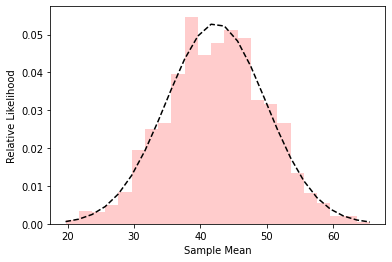

In [28]:
# Fitting sample means to a normal curve
likelihoods, bin_edges, _ = plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
mean, std = stats.norm.fit(sample_means)
normal_likelihoods = stats.norm.pdf(bin_edges, mean, std)

plt.plot(bin_edges, normal_likelihoods, color="k", linestyle="--")
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

Our histogram is not very smooth because we’ve only processed 100 data points. However,
the histogram’s shape still approximates a normal distribution.



In [29]:
# Comparing the normal mean to the population mean
print(f"Actual population mean is approximately {population_mean:.2f}")

percent_diff_means = percent_diff(mean, population_mean)
print(f"There is a {percent_diff_means:.2f} difference between means.")

Actual population mean is approximately 42.53
There is a 0.45 difference between means.


Thus our result, while not perfect, is still a very good approximation of
the actual average age within the town.

Now, we briefly turn our attention to the standard deviation computed from the
normal distribution.

**Squaring the standard deviation produces the distribution’s variance**.
According to the central limit theorem, we can use that variance to estimate the variance of ages in the town. 

We simply need to multiply the computed variance by the
sample size.

In [30]:
# Estimating the population variance
normal_variance = std ** 2
estimated_variance = normal_variance * sample_size

Let’s compare the estimated variance to the population variance.

In [31]:
# Comparing the estimated variance to the population variance
print(f"Estimated variance is approximately {estimated_variance:.2f}")
print(f"Actual population variance is approximately {population_variance:.2f}")

percent_diff_var = percent_diff(estimated_variance, population_variance)
print(f"There is a {percent_diff_var:.2f} percent difference between variances.")

Estimated variance is approximately 566.50
Actual population variance is approximately 584.33
There is a 3.05 percent difference between variances.


We’ve thus approximated the town’s variance to a relatively accurate
degree while sampling only 2% of the people living in the town. Our estimates
may not be 100% perfect. 

However, the amount of time we saved more than makes up
for that minuscule drop in accuracy.

So far, **we’ve only used the central limit theorem to estimate the population mean and variance**. 

However, **the power of the theorem goes beyond the mere estimation of
distribution parameters**. 

We can use the central limit theorem to make predictions
about people.

##Making predictions using the mean and variance

Let’s suppose the mean is equal to 84
and the variance is equal to 25. We’ll refer to these values as the population mean and
population variance.

In [32]:
# Population mean and variance of recorded grades
population_mean = 84
population_variance = 25  

The mean of the normal curve will equal `population_mean`. The variance of the normal curve will equal `population_variance` divided by our sample size of 20 students. Taking the square
root of that variance produces the standard deviation of the curve, which statisticians
call the standard error of the mean (SEM). 

By definition, the SEM equals the population
standard deviation divided by the square root of the sample size.

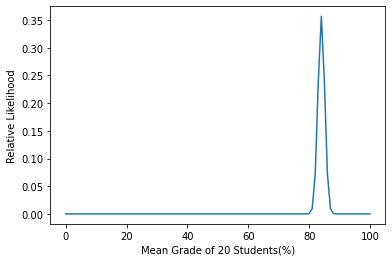

In [33]:
# Plotting a normal curve using the mean and SEM
mean = population_mean
# The population standard deviation equals the square root of the population variance
population_std = population_variance ** .5
# The SEM equals population_std divided by the square root of the sample size
sem = population_std / (20 ** 0.5)
grade_range = range(101)
normal_likelihoods = stats.norm.pdf(grade_range, mean , sem)

plt.plot(grade_range, normal_likelihoods)
plt.xlabel("Mean Grade of 20 Students(%)")
plt.ylabel("Relative Likelihood")
plt.show()

The area beneath the plotted curve approaches zero at values higher than 89%. That
area is also equal to the probability of a given observation.

Therefore, the probability
of observing a mean grade that’s at or above 90% is incredibly low. Still, to be sure, we
need to compute the actual probability. 

Thus, we need to somehow accurately measure
the area under the normal distribution.

###Computing the area beneath a normal curve

One simple solution is to subdivide the normal
curve into small, trapezoidal units. This ancient technique is referred to as the trapezoidal rule.

A trapezoid is a four-sided polygon with two parallel sides; the trapezoid’s
area is equal to the sum of these parallel sides multiplied by half the distance between
them. 

Summing over multiple consecutive trapezoid areas approximates the area over
an interval.

Let’s apply the trapezoidal rule to our normal distribution.

In [34]:
# Approximating the area using the trapezoidal rule

# The area of each trapezoid equals the sum of two consecutive likelihoods divided by 2.
total_area = np.sum([normal_likelihoods[i: i + 2].sum() / 2 for i in range(normal_likelihoods.size - 1)])

assert total_area == np.trapz(normal_likelihoods)
print(f"Estimated area under the curve is {total_area}")

Estimated area under the curve is 1.0000000000384808


The estimated area is very close to 1.0, but its not exactly equal to 1.0. We can access a mathematically exact solution in SciPy, using the `stats.norm.sf` method.

The survival function
equals the distribution’s area over an interval that’s greater than some x.

In [35]:
# Computing the total area using SciPy
assert stats.norm.sf(0, mean, sem) == 1.0

We expect `stats.norm.sf(mean, mean, sem)` to equal 0.5. This is because the mean perfectly splits the Normal curve into 2 equal halves. Meanwhile, we expect `np.trapz(normal_likelihoods[mean:])` to approximate but not fully equal 0.5. 

Lets confirm below.

In [36]:
# Inputting the mean into the survival function
assert stats.norm.sf(mean, mean, sem) == 0.5

In [37]:
estimated_area = np.trapz(normal_likelihoods[mean:])
print(f"Estimated area beyond the mean is {estimated_area}")

Estimated area beyond the mean is 0.5000000000192404


Now, lets execute stats.norm.sf(90, mean, sem). This will return the area over an interval of values lying beyond 90%. 

The area represents the likelihood of 20 students jointly acing an exam.

In [38]:
# Computing the probability of a good collective grade
area = stats.norm.sf(90, mean, sem)
print(f"Probability of 20 students acing the exam is {area}")

Probability of 20 students acing the exam is 4.012555633463782e-08


It seems our final conclusion is imperfect. We did the best we could, given what we
knew, but some uncertainty remains. 

To eliminate that uncertainty, we’d need the
missing dates for the graded exams. 

Unfortunately, that data was not provided. Quite
commonly, statisticians are forced to make consequential decisions from limited records.

Consequently,
we must exercise great caution when we draw conclusions from incomplete
information.